### Import Necessary Module and Set Path 

In [1]:
import sqlite3 as lite
import os
import sys
import numpy as np
from pyne import nucname
import collections
import matplotlib.pyplot as plt
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()

In [2]:
import analysis as an

## Run Cyclus Input file

In [81]:
! rm mixer.sqlite
! cyclus -o mixer.sqlite mixer.xml

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

In [15]:
! rm astrid.sqlite
! cyclus -o astrid.sqlite 1970-2160_Just_ASTRID.xml

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

### The output file should be named 
         
          astrid.sqlite

In [11]:
# Wait for the complete message to move on
filename = 'mixer.sqlite'

cur = an.get_cursor(filename)
init_year, init_month, duration, timestep = an.get_timesteps(cur)

# get power / number timeseries
an.plot_power(cur)

# get fuel source and inventory
fuel = an.fuel_usage_timeseries(cur, ['mox'])
an.stacked_bar_chart(fuel, timestep,
                  'Years', 'Mass[MTHM]',
                  'Total Fuel Mass vs Time',
                  'where_fuel',
                  init_year)

# plutonium flux
agent_ids = an.get_agent_ids(cur, 'separations')
pu = an.facility_commodity_flux(cur, agent_ids, ['uox_Pu', 'mox_Pu'], True)
pu['pu from legacy'] = pu.pop('uox_Pu')
pu['pu from spent sfr fuel'] = pu.pop('mox_Pu')
an.stacked_bar_chart(pu, timestep, 'Years', 'Mass [MTHM]', 'Total Pu Mass vs Time', 'pu', init_year)

fuel_dict = collections.OrderedDict()
fuel_dict['from spent uox'] = [x/.09 for x in pu['pu from legacy']]
fuel_dict['from spent mox'] = [x/.09 for x in pu['pu from spent sfr fuel']]
an.stacked_bar_chart(fuel_dict, timestep, 'Years', 'Mass [MTHM]', 'Total Fuel Mass vs Time', 'fuel', init_year)

tailings = collections.OrderedDict()
tailings['tailings used'] = [i * .91 for i in fuel['mox']]
an.stacked_bar_chart(tailings, timestep, 'Years', 'Mass [MTHM]', 'Total Tailings Usage vs Time', 'tails', init_year)



"""
# get pu demand
demand = collections.OrderedDict()
demand['pu_from_legacy'] = [i * .09 for i in fuel_dict['from_spent_uox']]
demand['pu_from_spent_mox'] = [i * .09 for i in fuel_dict['from_spent_mox']]
total_mox = ([x + y for x, y in zip(fuel_dict['from_spent_uox'], fuel_dict['from_spent_mox'])])
demand['pu_total'] = [i *.09 for i in total_mox]
demand['num_astrid'] = [i / 4.9 for i in demand['pu_from_legacy']]
demand['tailings'] = [i * .91 for i in total_mox]
an.multi_line_plot(demand, timestep,
                'Years', 'Mass[MTHM]',
                'Total Demand vs Time',
                'demand',
                init_year)
"""
print('Total MOX used in MTHM:')
print(max(fuel['mox']))
print('Total MOX from legacy UOX Waste in MTHM:')
print(max(fuel_dict['from spent uox']))
print('Total MOX from MOX Waste in MTHM:')
print(max(fuel_dict['from spent mox']))
print('Total Tailings used in MTHM:')
print(max(tailings['tailings used']))
print('Total Pu reprocessed in MTHM:')
print(max([x+y for x, y in zip(pu['pu from legacy'], pu['pu from spent sfr fuel'])]))


# get total legacy snf reprocessed:
x = cur.execute('SELECT sum(massfrac) FROM recipes LEFT OUTER JOIN compositions ON '
                'compositions.qualid = recipes.qualid '
                'WHERE recipe = "uox_used_fuel_recipe" '
                'and (nucid > 940000000 and nucid < 950000000)').fetchone()
y = cur.execute('SELECT sum(massfrac) FROM recipes LEFT OUTER JOIN compositions ON '
                'compositions.qualid = recipes.qualid '
                'WHERE recipe = "sfr_spent_mox_recipe" '
                'and (nucid > 940000000 and nucid < 950000000)').fetchone()
# print('Total Legacy SNF reprocessed: ')
# print(max(i / x[0] for i in pu['pu_from_legacy']))
dictionary = {}
rep_throughput_legacy = [i / x[0] for i in pu['pu from legacy']]
rep_throughput_mox = [i / y[0] for i in pu['pu from spent sfr fuel']]
dictionary['reprocessing throughput'] = [x + y for x, y in zip(rep_throughput_legacy, rep_throughput_mox)]
an.stacked_bar_chart(dictionary, timestep, 'Years', 'Reprocessing Throughput [MTHM]',
                     'Reprocessing Throughput vs Time', 'throughput', init_year)


# get reprocessing waste
agent_ids = an.get_agent_ids(cur, 'separations')
reprocess_waste = an.facility_commodity_flux(cur, agent_ids, ['uox_reprocess_waste', 'mox_reprocess_waste'], True)
an.stacked_bar_chart(reprocess_waste, timestep, 'Years', 'Mass [MTHM]',
                     'Reprocess Waste vs Time', 'reprocess_waste', init_year)

# get rep U inventory
rep_U = an.get_trade_dict(cur, 'separations', 'storage', False, False)

print('Total Reprocessed Uranium Stockpile: ')
print(max(rep_U))
print(max(rep_U['separ to stora']))

rep_U = an.get_trade_dict(cur, 'separations', 'storage', False, True)
an.stacked_bar_chart(rep_U, timestep, 'Years', 'Mass [MTHM]',
                     'Reprocessed U vs Time', 'rep_U', init_year)

# get Pu isotopics
trade_dict = an.get_trade_dict(cur, 'separations', 'mixer', False, False)
print('Total Reprocess Waste: ')
print(max(trade_dict['separ to mixer']))
trade_dict = an.get_trade_dict(cur, 'separations', 'mixer', False, True)
an.stacked_bar_chart(trade_dict, timestep, 'Years', 'Mass [MTHM]',
                     'Reprocessed Pu vs Time', 'rep_pu', init_year)


print('Finished!')

Sink_Source_Inst has no values
Sink_Source_Inst has no values
Total MOX used in MTHM:
116115.072
Total MOX from legacy UOX Waste in MTHM:
16372.2155369
Total MOX from MOX Waste in MTHM:
150426.875377
Total Tailings used in MTHM:
105664.71552
Total Pu reprocessed in MTHM:
15011.9181823
Total Reprocessed Uranium Stockpile: 
separ to stora
251100.555477
Total Reprocess Waste: 
15011.9181823
Finished!


In [16]:
# Wait for the complete message to move on
filename = 'astrid.sqlite'

cur = an.get_cursor(filename)
init_year, init_month, duration, timestep = an.get_timesteps(cur)

# get fuel source and inventory
fuel_dict = an.where_comm(
    cur, 'mox', ['mox_uox_fuel_fab', 'mox_mox_fuel_fab'])
fuel_dict['from_spent_uox'] = fuel_dict.pop('mox_uox_fuel_fab')
fuel_dict['from_spent_mox'] = fuel_dict.pop('mox_mox_fuel_fab')
an.stacked_bar_chart(fuel_dict, timestep,
                  'Years', 'Mass[MTHM]',
                  'Total Fuel Mass vs Time',
                  'where_fuel',
                  init_year)

# get pu demand
demand = collections.OrderedDict()
demand['pu_from_legacy'] = [i * .09 for i in fuel_dict['from_spent_uox']]
demand['pu_from_spent_mox'] = [i * .09 for i in fuel_dict['from_spent_mox']]
total_mox = ([x + y for x, y in zip(fuel_dict['from_spent_uox'], fuel_dict['from_spent_mox'])])
demand['pu_total'] = [i *.09 for i in total_mox]
demand['num_astrid'] = [i / 4.9 for i in demand['pu_from_legacy']]
demand['tailings'] = [i * .91 for i in total_mox]
an.multi_line_plot(demand, timestep,
                'Years', 'Mass[MTHM]',
                'Total Demand vs Time',
                'demand',
                init_year)
print('Total MOX used in MTHM:')
print(max(total_mox))
print('Total MOX from legacy UOX Waste in MTHM:')
print(max(fuel_dict['from_spent_uox']))
print('Total MOX from MOX Waste in MTHM:')
print(max(fuel_dict['from_spent_mox']))
print('Total Tailings used in MTHM:')
print(max(demand['tailings']))
print('Total Pu reprocessed in MTHM:')
print(max(demand['pu_total']))


# get total legacy snf reprocessed:
x = cur.execute('SELECT sum(massfrac) FROM recipes LEFT OUTER JOIN compositions ON '
                'compositions.qualid = recipes.qualid '
                'WHERE recipe = "uox_used_fuel_recipe" '
                'and (nucid > 940000000 and nucid < 950000000)').fetchone()
y = cur.execute('SELECT sum(massfrac) FROM recipes LEFT OUTER JOIN compositions ON '
                'compositions.qualid = recipes.qualid '
                'WHERE recipe = "sfr_spent_mox_recipe" '
                'and (nucid > 940000000 and nucid < 950000000)').fetchone()
print('Total Legacy SNF reprocessed: ')
print(max(i / x[0] for i in demand['pu_from_legacy']))
dictionary = {}
rep_throughput_legacy = [i / x[0] for i in demand['pu_from_legacy']]
rep_throughput_mox = [i / y[0] for i in demand['pu_from_spent_mox']]
dictionary['reprocess throughput'] = [x + y for x, y in zip(rep_throughput_legacy, rep_throughput_mox)]

# get power / number timeseries
an.plot_power(cur)

# get reprocessing waste
agent_ids = an.get_agent_ids(cur, 'separations')
reprocess_waste = an.facility_commodity_flux(cur, agent_ids, ['uox_reprocess_waste', 'mox_reprocess_waste'], True)
an.stacked_bar_chart(reprocess_waste, timestep, 'Years', 'Mass [MTHM]',
                     'Reprocess Waste vs Time', 'reprocess_waste', init_year)

# get Pu isotopics
trade_dict = an.get_trade_dict(cur, 'separations', 'fuelfab', False, True)
an.stacked_bar_chart(trade_dict, timestep, 'Years', 'Mass [MTHM]',
                     'Reprocessed Pu vs Time', 'rep_pu', init_year)

print('Finished!')

Total MOX used in MTHM:
169960.1
Total MOX from legacy UOX Waste in MTHM:
16381.5
Total MOX from MOX Waste in MTHM:
153578.6
Total Tailings used in MTHM:
154663.691
Total Pu reprocessed in MTHM:
15296.409
Total Legacy SNF reprocessed: 
157246.263528
Sink_Source_Inst has no values
Sink_Source_Inst has no values
['33', '34']
['28', '29']
SELECT time, sum(quantity)*massfrac, nucid FROM transactions INNER JOIN resources ON resources.resourceid = transactions.resourceid LEFT OUTER JOIN compositions ON compositions.qualid = resources.qualid WHERE (senderid = 33 OR senderid = 34) AND (receiverid = 28 OR receiverid = 29) GROUP BY time, nucid
Finished!


In [4]:
# Get double axes for pu and # astrid start.
fig, ax = plt.subplots()
ax2 = ax.twinx()
yaxis = an.timestep_to_years(init_year, timestep)
ax.plot(yaxis, demand['pu_from_legacy'], 'k')
ax.set_xlabel('time (s)')
ax.set_ylabel('total plutonium [tons]')

ax2.plot(yaxis, demand['num_astrid'], 'k')
ax2.set_ylabel('Number of ASTRIDs')

for t in ax.get_yticklabels():
    t.set_color('k')
for t in ax2.get_yticklabels():
    t.set_color('k')
plt.grid(True)
plt.savefig('Pu_Num_astrid.png',
                    format='png',
                    bbox_inches='tight')


In [5]:
# Fresh and Spent Fuel Composition
cur = an.get_cursor(filename)

sfr_fuel_qualid = cur.execute('SELECT qualid FROM transactions '
                              'INNER JOIN resources ON '
                              'resources.resourceid = transactions.resourceid '
                              'WHERE commodity = "mox"').fetchone()
fresh_sfr_mox_comp = cur.execute('SELECT nucid, massfrac FROM compositions '
                                 'WHERE qualid = ' + str(sfr_fuel_qualid[0])).fetchall()
print('Composition for fresh sfr fuel: ')
for isotope in fresh_sfr_mox_comp:
    print(nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %')

print('\n \n')

sfr_waste_comp = cur.execute('SELECT nucid, massfrac FROM recipes '
                             'LEFT OUTER JOIN compositions '
                             'ON recipes.qualid = compositions.qualid '
                             'WHERE recipe = "sfr_spent_mox_recipe"').fetchall()
print('Composition for fresh sfr spent fuel: ')
for isotope in sfr_waste_comp:
    print(nucname.name(isotope[0]) + ': ' + str(isotope[1] * 100) + ' %')

Composition for fresh sfr fuel: 
U235: 0.2730239374280984 %
U238: 90.73495520527135 %
Pu238: 0.10659409411644825 %
Pu239: 4.977360229327613 %
Pu240: 2.229865302638476 %
Pu241: 1.2104416968428016 %
Pu242: 0.46774720231950573 %
Pu244: 1.2332055710476654e-05 %

 

Composition for fresh sfr spent fuel: 
H3: 1.861709546285802e-05 %
He4: 0.0008340070322985747 %
Kr81: 8.564618921994767e-10 %
Kr85: 0.003143538324284237 %
Sr90: 0.05877950376970925 %
Tc99: 0.1782414638949942 %
I129: 0.056255335910956175 %
Cs134: 0.005744992216764006 %
Cs135: 0.30432882523365073 %
Cs137: 0.2684242617089776 %
Pb206: 1.2899313751333013e-16 %
Pb207: 2.016841306998443e-14 %
Pb208: 6.260127069923578e-09 %
Pb210: 8.676866111431851e-16 %
Bi209: 2.7710994371158423e-12 %
Ra226: 5.489299917832239e-12 %
Ra228: 5.225780481958388e-19 %
Ac227: 5.157912802220785e-13 %
Th228: 1.0697836894168597e-08 %
Th229: 4.3318489973791243e-10 %
Th230: 2.2797647781296572e-07 %
Th232: 4.715830589882708e-09 %
Pa231: 1.3856333486723872e-08 %
U23

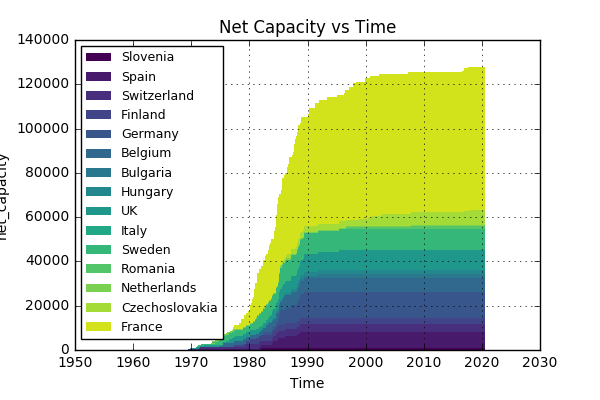

In [4]:
# Display Net Capacity vs Time
from IPython.display import Image
Image(filename='Net Capacity vs Time.png')

# Display Number of Reactors vs Time
from IPython.display import Image
Image(filename='Number of Reactors vs Time.png')

# Display fuel usage vs Time
from IPython.display import Image
Image(filename='where_fuel.png')

# Display tailings demand vs Time
from IPython.display import Image
Image(filename='tailings_demand.png')

# Display plutonium demand vs Time
from IPython.display import Image
Image(filename='pu_total_demand.png')

# Display reprocess waste vs Time
from IPython.display import Image
Image(filename='reprocess_waste.png')